In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


In [1]:
print (" hey! good evenings guys, this is Rajaram here ")

 hey! good evenings guys, this is Rajaram here 


In [7]:
df = pd.read_csv (r'C:\Users\raaja\Downloads\ml-latest-small\ml-latest-small\ratings.csv' )
print(df)

        userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]


In [8]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [9]:
df_movies = pd.read_csv(r'C:\Users\raaja\Downloads\ml-latest-small\ml-latest-small\movies.csv')
print(df_movies)

      movieId                                      title  \
0           1                           Toy Story (1995)   
1           2                             Jumanji (1995)   
2           3                    Grumpier Old Men (1995)   
3           4                   Waiting to Exhale (1995)   
4           5         Father of the Bride Part II (1995)   
...       ...                                        ...   
9737   193581  Black Butler: Book of the Atlantic (2017)   
9738   193583               No Game No Life: Zero (2017)   
9739   193585                               Flint (2017)   
9740   193587        Bungo Stray Dogs: Dead Apple (2018)   
9741   193609        Andrew Dice Clay: Dice Rules (1991)   

                                           genres  
0     Adventure|Animation|Children|Comedy|Fantasy  
1                      Adventure|Children|Fantasy  
2                                  Comedy|Romance  
3                            Comedy|Drama|Romance  
4                  

In [10]:
df_movies = pd.read_csv(r'C:\Users\raaja\Downloads\ml-latest-small\ml-latest-small\movies.csv')
df_join = pd.merge(df_movies, df, how='inner', on='movieId')
df_join.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [11]:
def get_ratings_matrix(df, train_size=0.75):
    user_to_row = {}
    movie_to_column = {}
    df_values = df.values
    n_dims = 10
    parameters = {}
    
    uniq_users = np.unique(df_values[:, 3])
    uniq_movies = np.unique(df_values[:, 0])

    for i, user_id in enumerate(uniq_users):
        user_to_row[user_id] = i

    for j, movie_id in enumerate(uniq_movies):
        movie_to_column[movie_id] = j
    
    n_users = len(uniq_users)
    n_movies = len(uniq_movies)
    
    R = np.zeros((n_users, n_movies))
    
    df_copy = df.copy()
    train_set = df_copy.sample(frac=train_size, random_state=0)
    test_set = df_copy.drop(train_set.index)
    
    for index, row in train_set.iterrows():
        i = user_to_row[row.userId]
        j = movie_to_column[row.movieId]
        R[i, j] = row.rating

    return R, train_set, test_set, n_dims, n_users, n_movies, user_to_row, movie_to_column

In [12]:
R, train_set, test_set, n_dims, n_users, n_movies, user_to_row, movie_to_column = get_ratings_matrix(df_join, 0.8)
parameters = {}

In [13]:
def initialize_parameters(lambda_U, lambda_V):
    U = np.zeros((n_dims, n_users), dtype=np.float64)
    V = np.random.normal(0.0, 1.0 / lambda_V, (n_dims, n_movies))
    
    parameters['U'] = U
    parameters['V'] = V
    parameters['lambda_U'] = lambda_U
    parameters['lambda_V'] = lambda_V

In [14]:
def update_parameters():
    U = parameters['U']
    V = parameters['V']
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    
    for i in range(n_users):
        V_j = V[:, R[i, :] > 0]
        U[:, i] = np.dot(np.linalg.inv(np.dot(V_j, V_j.T) + lambda_U * np.identity(n_dims)), np.dot(R[i, R[i, :] > 0], V_j.T))
        
    for j in range(n_movies):
        U_i = U[:, R[:, j] > 0]
        V[:, j] = np.dot(np.linalg.inv(np.dot(U_i, U_i.T) + lambda_V * np.identity(n_dims)), np.dot(R[R[:, j] > 0, j], U_i.T))
        
    parameters['U'] = U
    parameters['V'] = V

In [15]:
def log_a_posteriori():
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    U = parameters['U']
    V = parameters['V']
    
    UV = np.dot(U.T, V)
    R_UV = (R[R > 0] - UV[R > 0])
    
    return -0.5 * (np.sum(np.dot(R_UV, R_UV.T)) + lambda_U * np.sum(np.dot(U, U.T)) + lambda_V * np.sum(np.dot(V, V.T)))

In [16]:
def predict(user_id, movie_id):
    U = parameters['U']
    V = parameters['V']
    
    r_ij = U[:, user_to_row[user_id]].T.reshape(1, -1) @ V[:, movie_to_column[movie_id]].reshape(-1, 1)

    max_rating = parameters['max_rating']
    min_rating = parameters['min_rating']

    return 0 if max_rating == min_rating else ((r_ij[0][0] - min_rating) / (max_rating - min_rating)) * 5.0

In [17]:
def evaluate(dataset):
    ground_truths = []
    predictions = []
    
    for index, row in dataset.iterrows():
        ground_truths.append(row.loc['rating'])
        predictions.append(predict(row.loc['userId'], row.loc['movieId']))
    
    return mean_squared_error(ground_truths, predictions, squared=False)

In [18]:
def update_max_min_ratings():
    U = parameters['U']
    V = parameters['V']

    R = U.T @ V
    min_rating = np.min(R)
    max_rating = np.max(R)

    parameters['min_rating'] = min_rating
    parameters['max_rating'] = max_rating

In [19]:
def train(n_epochs):
    initialize_parameters(0.3, 0.3)
    log_aps = []
    rmse_train = []
    rmse_test = []

    update_max_min_ratings()
    rmse_train.append(evaluate(train_set))
    rmse_test.append(evaluate(test_set))
    
    for k in range(n_epochs):
        update_parameters()
        log_ap = log_a_posteriori()
        log_aps.append(log_ap)

        if (k + 1) % 10 == 0:
            update_max_min_ratings()

            rmse_train.append(evaluate(train_set))
            rmse_test.append(evaluate(test_set))
            print('Log p a-posteriori at iteration', k + 1, ':', log_ap)

    update_max_min_ratings()

    return log_aps, rmse_train, rmse_test

In [20]:
log_ps, rmse_train, rmse_test = train(150)

Log p a-posteriori at iteration 10 : -17779.34728799867
Log p a-posteriori at iteration 20 : -13401.997244330003
Log p a-posteriori at iteration 30 : -12443.977756347616
Log p a-posteriori at iteration 40 : -12110.057743568437
Log p a-posteriori at iteration 50 : -11958.710579991535
Log p a-posteriori at iteration 60 : -11858.984018113097
Log p a-posteriori at iteration 70 : -11780.677945942649
Log p a-posteriori at iteration 80 : -11713.05934536403
Log p a-posteriori at iteration 90 : -11657.784199744321
Log p a-posteriori at iteration 100 : -11589.433208189004
Log p a-posteriori at iteration 110 : -11512.792193319883
Log p a-posteriori at iteration 120 : -11440.94081794617
Log p a-posteriori at iteration 130 : -11375.598594011335
Log p a-posteriori at iteration 140 : -11312.496007907423
Log p a-posteriori at iteration 150 : -11254.635079673591


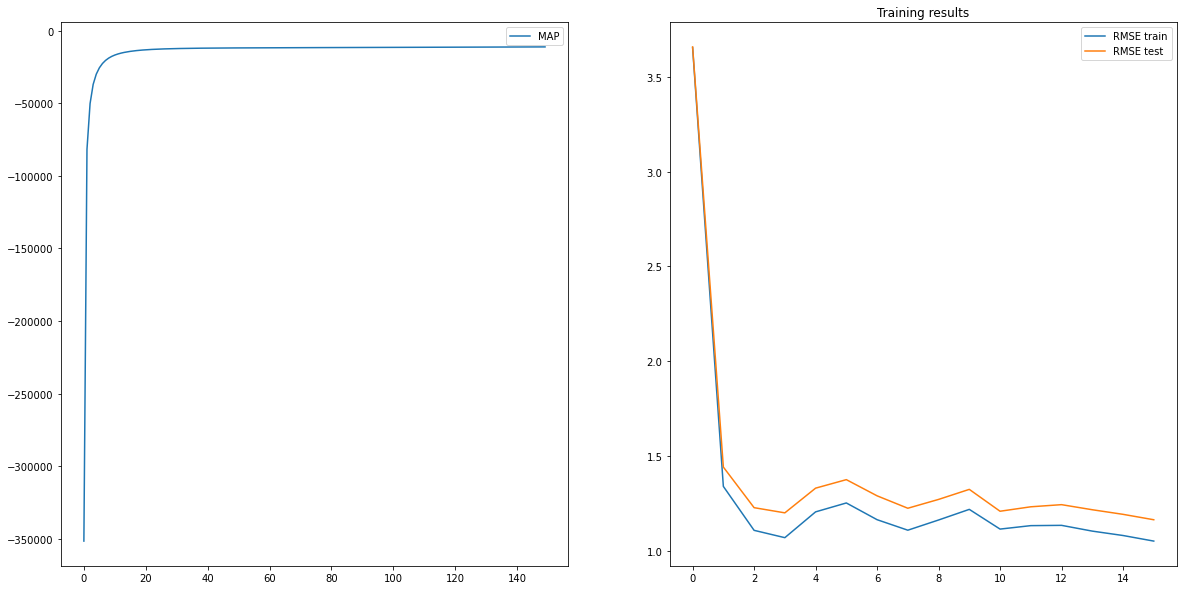

In [21]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title('Training results')
ax1.plot(np.arange(len(log_ps)), log_ps, label='MAP')
ax1.legend()

ax2.plot(np.arange(len(rmse_train)), rmse_train, label='RMSE train')
ax2.plot(np.arange(len(rmse_test)), rmse_test, label='RMSE test')
ax2.legend()

plt.show()

In [22]:
print('RMSE of training set:', evaluate(train_set))
print('RMSE of testing set:', evaluate(test_set))

RMSE of training set: 1.0524953209661287
RMSE of testing set: 1.1649755198411202


In [23]:
user_id = 45
df_join[df_join['userId'] == user_id].sort_values(by=['rating'], ascending=False).head(10)

,movieId,title,genres,userId,rating,timestamp
39202,2078,"Jungle Book, The (1967)",Animation|Children|Comedy|Musical,45,5.0,950726248
46609,2694,Big Daddy (1999),Comedy,45,5.0,951170525
46142,2657,"Rocky Horror Picture Show, The (1975)",Comedy|Horror|Musical|Sci-Fi,45,5.0,950741248
55533,3578,Gladiator (2000),Action|Adventure|Drama,45,5.0,1020803425
33101,1584,Contact (1997),Drama|Sci-Fi,45,5.0,950740871
56625,3717,Gone in 60 Seconds (2000),Action|Crime,45,5.0,1007994717
45369,2580,Go (1999),Comedy|Crime,45,5.0,951756858
56996,3753,"Patriot, The (2000)",Action|Drama|War,45,5.0,1007995101
57287,3793,X-Men (2000),Action|Adventure|Sci-Fi,45,5.0,1007995171
57418,3798,What Lies Beneath (2000),Drama|Horror|Mystery,45,5.0,1007995171


In [24]:
df_join[df_join['userId'] == user_id].sort_values(by=['rating']).head(10)

,movieId,title,genres,userId,rating,timestamp
53154,3270,"Cutting Edge, The (1992)",Comedy|Drama|Romance,45,1.0,950718581
5111,173,Judge Dredd (1995),Action|Crime|Sci-Fi,45,1.0,950741335
44072,2470,Crocodile Dundee (1986),Adventure|Comedy,45,1.0,950740565
67895,5585,Ernest Scared Stupid (1991),Comedy,45,1.0,1034344038
62486,4502,Ernest Saves Christmas (1988),Children|Comedy,45,1.0,1034344018
60222,4104,Ernest Goes to Camp (1987),Comedy,45,1.0,1034344018
53115,3268,Stop! Or My Mom Will Shoot (1992),Action|Comedy,45,1.0,950740376
46306,2672,"Thirteenth Floor, The (1999)",Drama|Sci-Fi|Thriller,45,1.0,950741061
54299,3439,Teenage Mutant Ninja Turtles II: The Secret of...,Action|Children|Fantasy,45,1.0,1034344018
15160,569,Little Big League (1994),Comedy|Drama,45,2.0,950722240


In [25]:
predictions = np.zeros((n_movies, 1))
movie_to_column_items = np.array(list(movie_to_column.items()))
df_result = pd.DataFrame(columns=['UserID', 'MovieID', 'Movie', 'Genres', 'Prediction'])

for i, movie in enumerate(movie_to_column_items):
    predictions[i] = predict(user_id, movie[0])
    
indices = np.argsort(-predictions, axis=0)

for j in range(10):
    movie_id = int(movie_to_column_items[np.where(movie_to_column_items[:, 1] == indices[j])][0][0])
    df_row = pd.DataFrame({
        'UserID': user_id,
        'MovieID': movie_id,
        'Movie': df_movies[df_movies['movieId'] == movie_id].iloc[0]['title'],
        'Genres': df_movies[df_movies['movieId'] == movie_id].iloc[0]['genres'],
        'Prediction': predictions[indices[j]][0][0]
    }, index=[j])
    df_result = df_result.append(df_row, sort=False)
    
df_result

,UserID,MovieID,Movie,Genres,Prediction
0,45,34338,"Aristocrats, The (2005)",Comedy|Documentary,3.659472
1,45,94677,"Dictator, The (2012)",Comedy,3.654936
2,45,3040,Meatballs (1979),Comedy,3.625464
3,45,7099,Nausicaä of the Valley of the Wind (Kaze no ta...,Adventure|Animation|Drama|Fantasy|Sci-Fi,3.603388
4,45,2459,"Texas Chainsaw Massacre, The (1974)",Horror,3.588282
5,45,102903,Now You See Me (2013),Crime|Mystery|Thriller,3.572142
6,45,909,"Apartment, The (1960)",Comedy|Drama|Romance,3.557141
7,45,5971,My Neighbor Totoro (Tonari no Totoro) (1988),Animation|Children|Drama|Fantasy,3.531683
8,45,3250,Alive (1993),Drama,3.529444
9,45,599,"Wild Bunch, The (1969)",Adventure|Western,3.517991


In [26]:
df_result = pd.DataFrame(columns=['UserID', 'MovieID', 'Movie', 'Genres', 'Prediction'])
indices = np.argsort(predictions, axis=0)

for j in range(10):
    movie_id = int(movie_to_column_items[np.where(movie_to_column_items[:, 1] == indices[j])][0][0])
    df_row = pd.DataFrame({
        'UserID': user_id,
        'MovieID': movie_id,
        'Movie': df_movies[df_movies['movieId'] == movie_id].iloc[0]['title'],
        'Genres': df_movies[df_movies['movieId'] == movie_id].iloc[0]['genres'],
        'Prediction': predictions[indices[j]][0][0]
    }, index=[j])
    df_result = df_result.append(df_row, sort=False)
    
df_result

,UserID,MovieID,Movie,Genres,Prediction
0,45,2901,Phantasm (1979),Horror|Sci-Fi,1.608660
1,45,70946,Troll 2 (1990),Fantasy|Horror,1.926836
2,45,61350,Babylon A.D. (2008),Action|Adventure|Sci-Fi|Thriller,1.954486
3,45,851,Basquiat (1996),Drama,2.021135
4,45,132046,Tomorrowland (2015),Action|Adventure|Children|Mystery|Sci-Fi,2.074427
5,45,631,All Dogs Go to Heaven 2 (1996),Adventure|Animation|Children|Fantasy|Musical|R...,2.085434
6,45,3851,I'm the One That I Want (2000),Comedy,2.092746
7,45,106,Nobody Loves Me (Keiner liebt mich) (1994),Comedy|Drama,2.112933
8,45,4074,"Legend of Rita, The (Stille nach dem Schuß, Di...",Drama,2.133119
9,45,2382,Police Academy 5: Assignment: Miami Beach (1988),Comedy|Crime,2.134995
